# This notebook visualizes a trained reCNN network
#### Last reviewed on Feb 17 2023

In [9]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path("").resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import wandb
import glob
from models import reCNN_bottleneck_CyclicGauss3d_no_scaling
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torchvision.transforms as transforms
import math
from Antolik_dataset import AntolikDataset, AntolikDataModule
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance
import pytorch_lightning as pl
import torch

In [10]:
from train_on_antolik import get_config
from model_trainer import Antolik_dataset_preparation_function, get_model

ENTITY = "csng-cuni"
PROJECT = "reCNN_visual_prosthesis"

model = None


##################################################################
# MODEL
needs_ground_truth = False
model_needs_dataloader = True
init_to_ground_truth_positions = True
init_to_ground_truth_orientations = True
do_not_sample = True # POZOR

# TRAINING
train_on_test = True
max_epochs = 500
max_time = 4
patience = 7
train_on_val = False
test = True
seed = 42
batch_size = 15
lr = 0.001

# DATASET
brain_crop = 0.5 #None # 0.8
# brain_crop = None
stimulus_crop = None # "auto" or [110, 110]

# only on of these can be True (or neither of them), if both were, it would be a double negation and reCNN would be set to the same y as the ground truth 
negative_y_coordinate = True # this says that readout has to put minus in front of y
positions_minus_y = False # this says that dataset has to put minus in front of y when loading the ground truth


################################################################

config = get_config(
    needs_ground_truth,
    model_needs_dataloader,
    init_to_ground_truth_positions,
    init_to_ground_truth_orientations,
    do_not_sample,
    train_on_test,
    max_epochs,
    max_time,
    patience,
    train_on_val,
    test,
    seed,
    batch_size,
    lr,
    brain_crop,
    stimulus_crop,
    negative_y_coordinate,
    positions_minus_y,
)

dm = Antolik_dataset_preparation_function(config, load_data=True)



Data loaded successfully!
Loaded precomputed mean from /storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized/ten_trials_mean.npy


In [11]:
m = get_model(config, dm, reCNN_bottleneck_CyclicGauss3d_no_scaling)

/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/auto/budejovice1/mpicek/reCNN_visual_prosthesis/readout.py:366: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


In [16]:
save = True

plt.rcParams.update({'font.size': 12})
img_path = "img/"
model_class = reCNN_bottleneck_CyclicGauss3d_no_scaling


# We visualize the expected and estimated orientation map
In this case, they should be same as the model is set to ground truth

Shift:
92.57142857142858


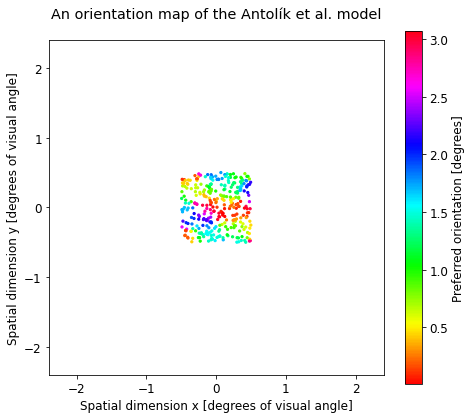

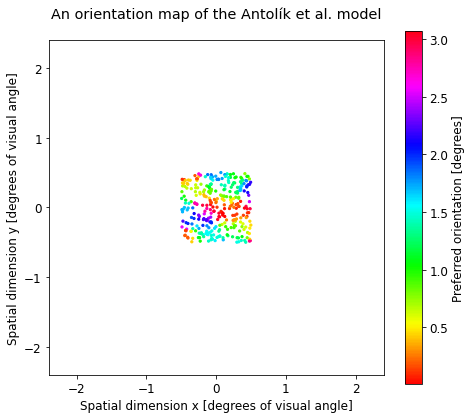

In [23]:
def get_shift(config, model, dm):

    factor = dm.get_stimulus_visual_angle()/2
    _, _, target_ori = dm.get_ground_truth(config["ground_truth_positions_file_path"], config["ground_truth_orientations_file_path"])
    _, _, ori = get_neuron_estimates(m, scale_factor=dm.get_stimulus_visual_angle()/2)

    predicted_ori = np.array(ori)  # [0, 1]
    predicted_ori = 180 * predicted_ori # [0, 180]
    target_ori = 180 * target_ori / np.pi # from [0, pi] to [0, 180]

    result = rotate_and_compute_distances(predicted_ori, target_ori, period=180, n_rot=36)
    print("Shift:")
    print(result[1][np.argmin(result[0])])
    shift = result[1][np.argmin(result[0])]

    # we align the predicted orientations with the ground truth rotations (to have the same shift)
    predicted_ori_aligned = (predicted_ori + shift) % 180

    return shift



shift = get_shift(config, m, dm)
dm.visualize_orientation_map(config["ground_truth_positions_file_path"], config["ground_truth_orientations_file_path"])
m.visualize_orientation_map(config["ground_truth_positions_file_path"], config["ground_truth_orientations_file_path"], factor=dm.get_stimulus_visual_angle()/2, shift=shift, swap_y_axis=True)

# We visualize how much the estimated positions are off

I'll visualize 322 neurons out of 322 neurons.
The average distance error in x is 7.593998374232847e-09
The average distance error in y is 7.348748391040149e-09
The average distance error is 1.2002438996546645e-08
saved


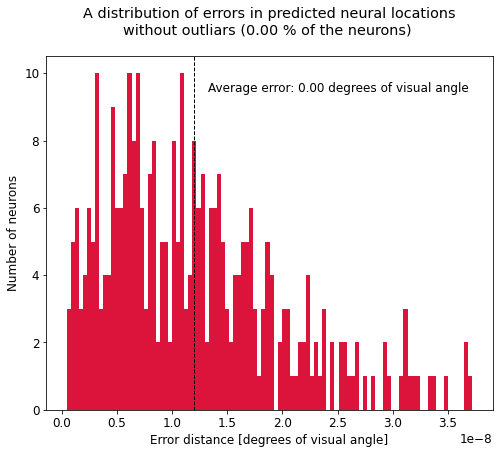

<Figure size 432x288 with 0 Axes>

In [24]:
def visualize_offness():
    factor = dm.get_stimulus_visual_angle()/2
    target_x, target_y, target_ori = dm.get_ground_truth(config["ground_truth_positions_file_path"], config["ground_truth_orientations_file_path"])
    x, y, ori = get_neuron_estimates(m, scale_factor=dm.get_stimulus_visual_angle()/2)

    predicted_ori = np.array(ori)  # [0, 1]
    predicted_ori = 180 * predicted_ori # [0, 180]
    target_ori = 180 * target_ori / np.pi # from [0, pi] to [0, 180]
    result = rotate_and_compute_distances(predicted_ori, target_ori, period=180, n_rot=36)
    shift = result[1][np.argmin(result[0])]

    # we align the predicted orientations with the ground truth rotations (to have the same shift)
    predicted_ori_aligned = (predicted_ori + shift) % 180




    visualize_neurons = []
    threshold = 1.0

    # measure the errors in positions
    num_neurons = len(x)
    s_x = np.zeros((num_neurons))
    s_y = np.zeros((num_neurons))
    for i in range(num_neurons):
        s_x[i] = abs(x[i] - target_x[i])
        s_y[i] = abs(y[i] + target_y[i]) # it is upside down
        if np.sqrt(s_x[i]**2 + s_y[i]**2) < threshold:
            visualize_neurons.append(i)

    print(f"I'll visualize {len(visualize_neurons)} neurons out of {len(x)} neurons.")
    # visualize_neurons = np.array(visualize_neurons)

    avg_x = np.sum(s_x)/num_neurons
    avg_y = np.sum(s_y)/num_neurons

    distances = np.sqrt(s_x**2 + s_y**2)

    print(f"The average distance error in x is {avg_x}")
    print(f"The average distance error in y is {avg_y}")
    print(f"The average distance error is {np.sum(distances)/num_neurons}")

    avg_error = np.mean(distances)
    distances = [x for x in distances if x < 30 * factor] # delete outliers
    # distances = [x for x in distances if x < 0.1 * factor] # delete outliers

    # and finally plot the distribution of distance errors
    plt.gcf().set_size_inches(8, 6.5)
    plt.hist(distances, bins=100, color="crimson")
    plt.axvline(avg_error, color='k', linestyle='dashed', linewidth=1)

    min_ylim, max_ylim = plt.ylim()
    plt.text(avg_error*1.1, max_ylim*0.9, 'Average error: {:.2f} degrees of visual angle'.format(avg_error))
    plt.title("A distribution of errors in predicted neural locations\nwithout outliars ({:.2f} % of the neurons) \n".format((1 - len(distances)/num_neurons) * 100))
    plt.xlabel("Error distance [degrees of visual angle]")
    plt.ylabel("Number of neurons")
    if save:
        plt.savefig(img_path + "distribution_of_distances_errors", dpi = 300)
        print("saved")
    plt.show()
    plt.clf()

visualize_offness()

# The rest of this is useless, won't be used. Kept only in case..

In [6]:
############################ ON ANTOLIK'S DATASET ##############################

# m = download_model(artifact_name="csng-cuni/reCNN_visual_prosthesis/model-y1w3szcc:v0", model_class=model_class)



Average orientation error:
42.28041180780331
Shift:
174.85714285714286
Reconstructed orientation maps are saved in img/reconstructed_orientation_map_antolik.fig


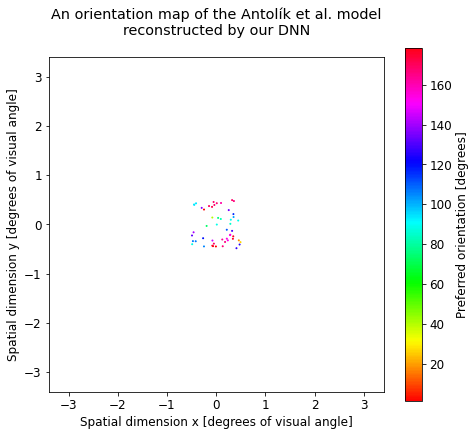

Reconstructed orientation maps are saved in img/true_orientation_map_of_antolik_model.fig


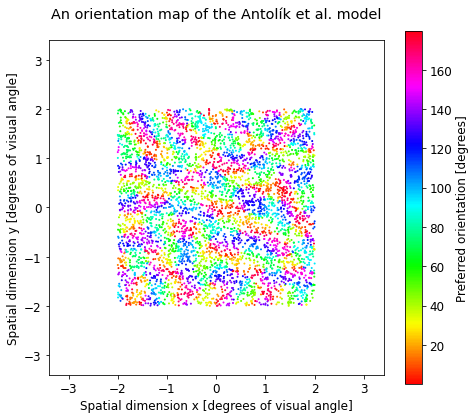

In [21]:
#####################################################################################
############################### Orientation errors ##################################
#####################################################################################

predicted_ori = np.array(ori)  # [0, 1]
predicted_ori = 180 * predicted_ori # [0, 180]
target_ori = 180 * target_ori / np.pi # from [0, pi] to [0, 180]

result = rotate_and_compute_distances(predicted_ori, target_ori, period=180, n_rot=36)


f, ax = plt.subplots()

print("Average orientation error:")
print(result[0][np.argmin(result[0])])

print("Shift:")
print(result[1][np.argmin(result[0])])
shift = result[1][np.argmin(result[0])]

distances = circular_distance(((predicted_ori + shift) % 180), target_ori, 180) 

# we align the predicted orientations with the ground truth rotations (to have the same shift)
predicted_ori_aligned = (predicted_ori + shift) % 180 
# reconstruct_orientation_maps(x, y, predicted_ori_aligned, f, ax, save, 12, 3.4, 3.4, img_path, "_antolik")
# visualize_preferred_orientations(x, y, predicted_ori_aligned, f, ax, save, 12, 2.4, 2.4, img_path, "_antolik")

reconstruct_orientation_maps(x[visualize_neurons], y[visualize_neurons], predicted_ori_aligned[visualize_neurons], f, ax, save, 12, 3.4, 3.4, img_path, "_antolik")

x = target_positions[:, 0]
y = target_positions[:, 1]
y = y # as the y coordinate is upside down

f, ax = plt.subplots()
reconstruct_orientation_maps(x, y, target_ori, f, ax, save, 12, 3.4, 3.4, img_path, "_truth")
# visualize_preferred_orientations(x, y, target_ori, f, ax, save, 12, 2.4, 2.4, img_path, "_truth")



saved


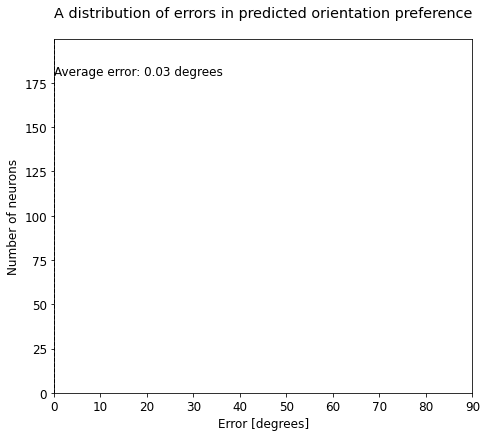

<Figure size 432x288 with 0 Axes>

In [ ]:
# visualize the distribution of orientation errors
avg_error = np.mean(distances)
plt.gcf().set_size_inches(7.5, 6.5)
plt.hist(distances, bins=100, color="crimson")
plt.axvline(avg_error, color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_error*1.1, max_ylim*0.9, 'Average error: {:.2f} degrees'.format(avg_error))
plt.xlim(0, 90)
plt.title("A distribution of errors in predicted orientation preference\n")
plt.xlabel("Error [degrees]")
plt.ylabel("Number of neurons")
if save:
    plt.savefig(img_path + "distribution_of_orientation_errors", dpi = 300)
    print("saved")
plt.show()
plt.clf()